In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

from scipy import stats
from adjustText import adjust_text
from statsmodels.stats.multitest import multipletests


sc.settings.verbosity = 3
sc.set_figure_params(figsize=(8.5, 8), dpi=150)

/root/data1/GY/Mambaforge/envs/openbiomed/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load_files

In [2]:
adata2 = sc.read_h5ad('../../processed_data/CDSDB_mdmt_613.h5ad')
adata2

AnnData object with n_obs × n_vars = 613 × 978
    obs: 'Sample ID', 'Base/Post', 'CDS-DB patient signature list', 'CDS-DB dataset list', 'Patient ID', 'Sampling location', 'Sampling time', 'Annotation of the therapeutic regimen from the data source', 'Therapeutic Regimen Recorded In The Data Source', 'Therapeutic regimen', 'Therapeutic regimen ID', 'Administration dose', 'Additional information about the therapeutic regimen', 'Drug category', 'Source dataset', 'Source database', 'Reference (PubMed ID)', 'Data type', 'Platform', 'Cancer subtype recorded in the data source', 'Cancer subtype', 'DOID of cancer subtype', 'Sampling location category', 'Additional information about the cancer', 'Original response status', 'Response group', 'Pediatric oncology', 'Predefined grouping criteria of response and non-response groups', 'Drug category_compact', 'sample_id_unique', 'pair_match_id', 'pert_time', 'pert_time_idx', 'pert_dose', 'pert_dose_unit', 'pert_dose_idx', 'pert_id', 'pert_idx', 'ti

In [3]:
adata2_breast = adata2[adata2.obs["split_breast_GSE20181"] != 0]

adata2_breast_ctl = sc.AnnData(X=adata2_breast.obsm["X_ctl"], obs=adata2_breast.obs,
                                     var = adata2_breast.var,
                                     uns=adata2_breast.uns)
adata2_breast.n_obs

114

# ctl: response v.s non-response

In [7]:
def generate_df(adata):
    
    adata = adata[adata.obs["Response group"]!='unknown']
    adata = adata[adata.obs.sort_values(by='Response group', ascending=False).index,:]
    
    response_group_statics = dict(adata.obs["Response group"].value_counts())
    response_num = response_group_statics["Response"]
    
    df = pd.DataFrame(adata.X.T, index=adata.var_names, columns=adata.obs["Response group"])
    df = np.power(2, df)
    
    df['NON/RES'] = np.mean(df.values[:,response_num:],1)/np.mean(df.values[:,:response_num],1)
    df['P-value'] = [stats.ttest_ind(a,b)[1] for a,b in zip(df.values[:,response_num:], df.values[:,:response_num])]
    
    return df

In [8]:
pd_df = generate_df(adata2_breast_ctl)
pd_df.head()

/root/data1/GY/Mambaforge/envs/openbiomed/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Response group,Response,Response,Response,Response,Response,Response,Response,Response,Response,Response,...,Non-response,Non-response,Non-response,Non-response,Non-response,Non-response,Non-response,Non-response,NON/RES,P-value
gene_symbol,,,,,,,,,,,,,,,,,,,,,
DDR1,3122.583412,2451.005643,3122.583412,2300.487313,1814.354322,1940.683391,3022.032505,1212.357528,1900.577533,1590.679287,...,1557.484872,2775.933980,1962.549326,1962.549326,1681.829848,1804.594851,1856.327468,1312.574956,0.937394,7.614870e-02
PAX8,964.051531,1291.582554,964.051531,1443.340529,853.236082,915.949452,923.996987,734.942845,1072.929043,665.573699,...,607.738856,669.290503,1178.533501,1178.533501,1033.374117,816.121598,954.276776,906.816932,0.959984,1.055307e-01
RPS5,4050.742110,1624.973850,4050.742110,1609.419570,2372.045262,3911.392252,5489.444871,3509.495760,3383.455222,4590.290888,...,2841.807335,6182.548077,2741.759161,2741.759161,7308.686821,1312.828830,4014.419772,3489.337977,0.783622,3.263787e-03
ABCF1,686.371087,589.139841,686.371087,603.559750,333.459582,603.581193,582.457197,481.403018,670.808785,549.329066,...,487.131255,671.001541,654.311147,654.311147,491.129855,408.405254,670.553052,536.890248,0.955308,1.758200e-01
SPAG7,829.551192,742.484327,829.551192,830.041927,645.341016,752.686252,1051.439185,1049.028458,913.049360,963.966067,...,699.326500,660.315714,729.123464,729.123464,615.768594,630.384654,706.891427,833.599774,0.771463,6.130166e-07


                    x          y    group
gene_symbol                              
DDR1        -0.093272   3.715037  #C3C1C0
PAX8        -0.058917   3.244266  #C3C1C0
RPS5        -0.351770   8.259237     grey
ABCF1       -0.065963   2.507829  #C3C1C0
SPAG7       -0.374331  20.637571     grey


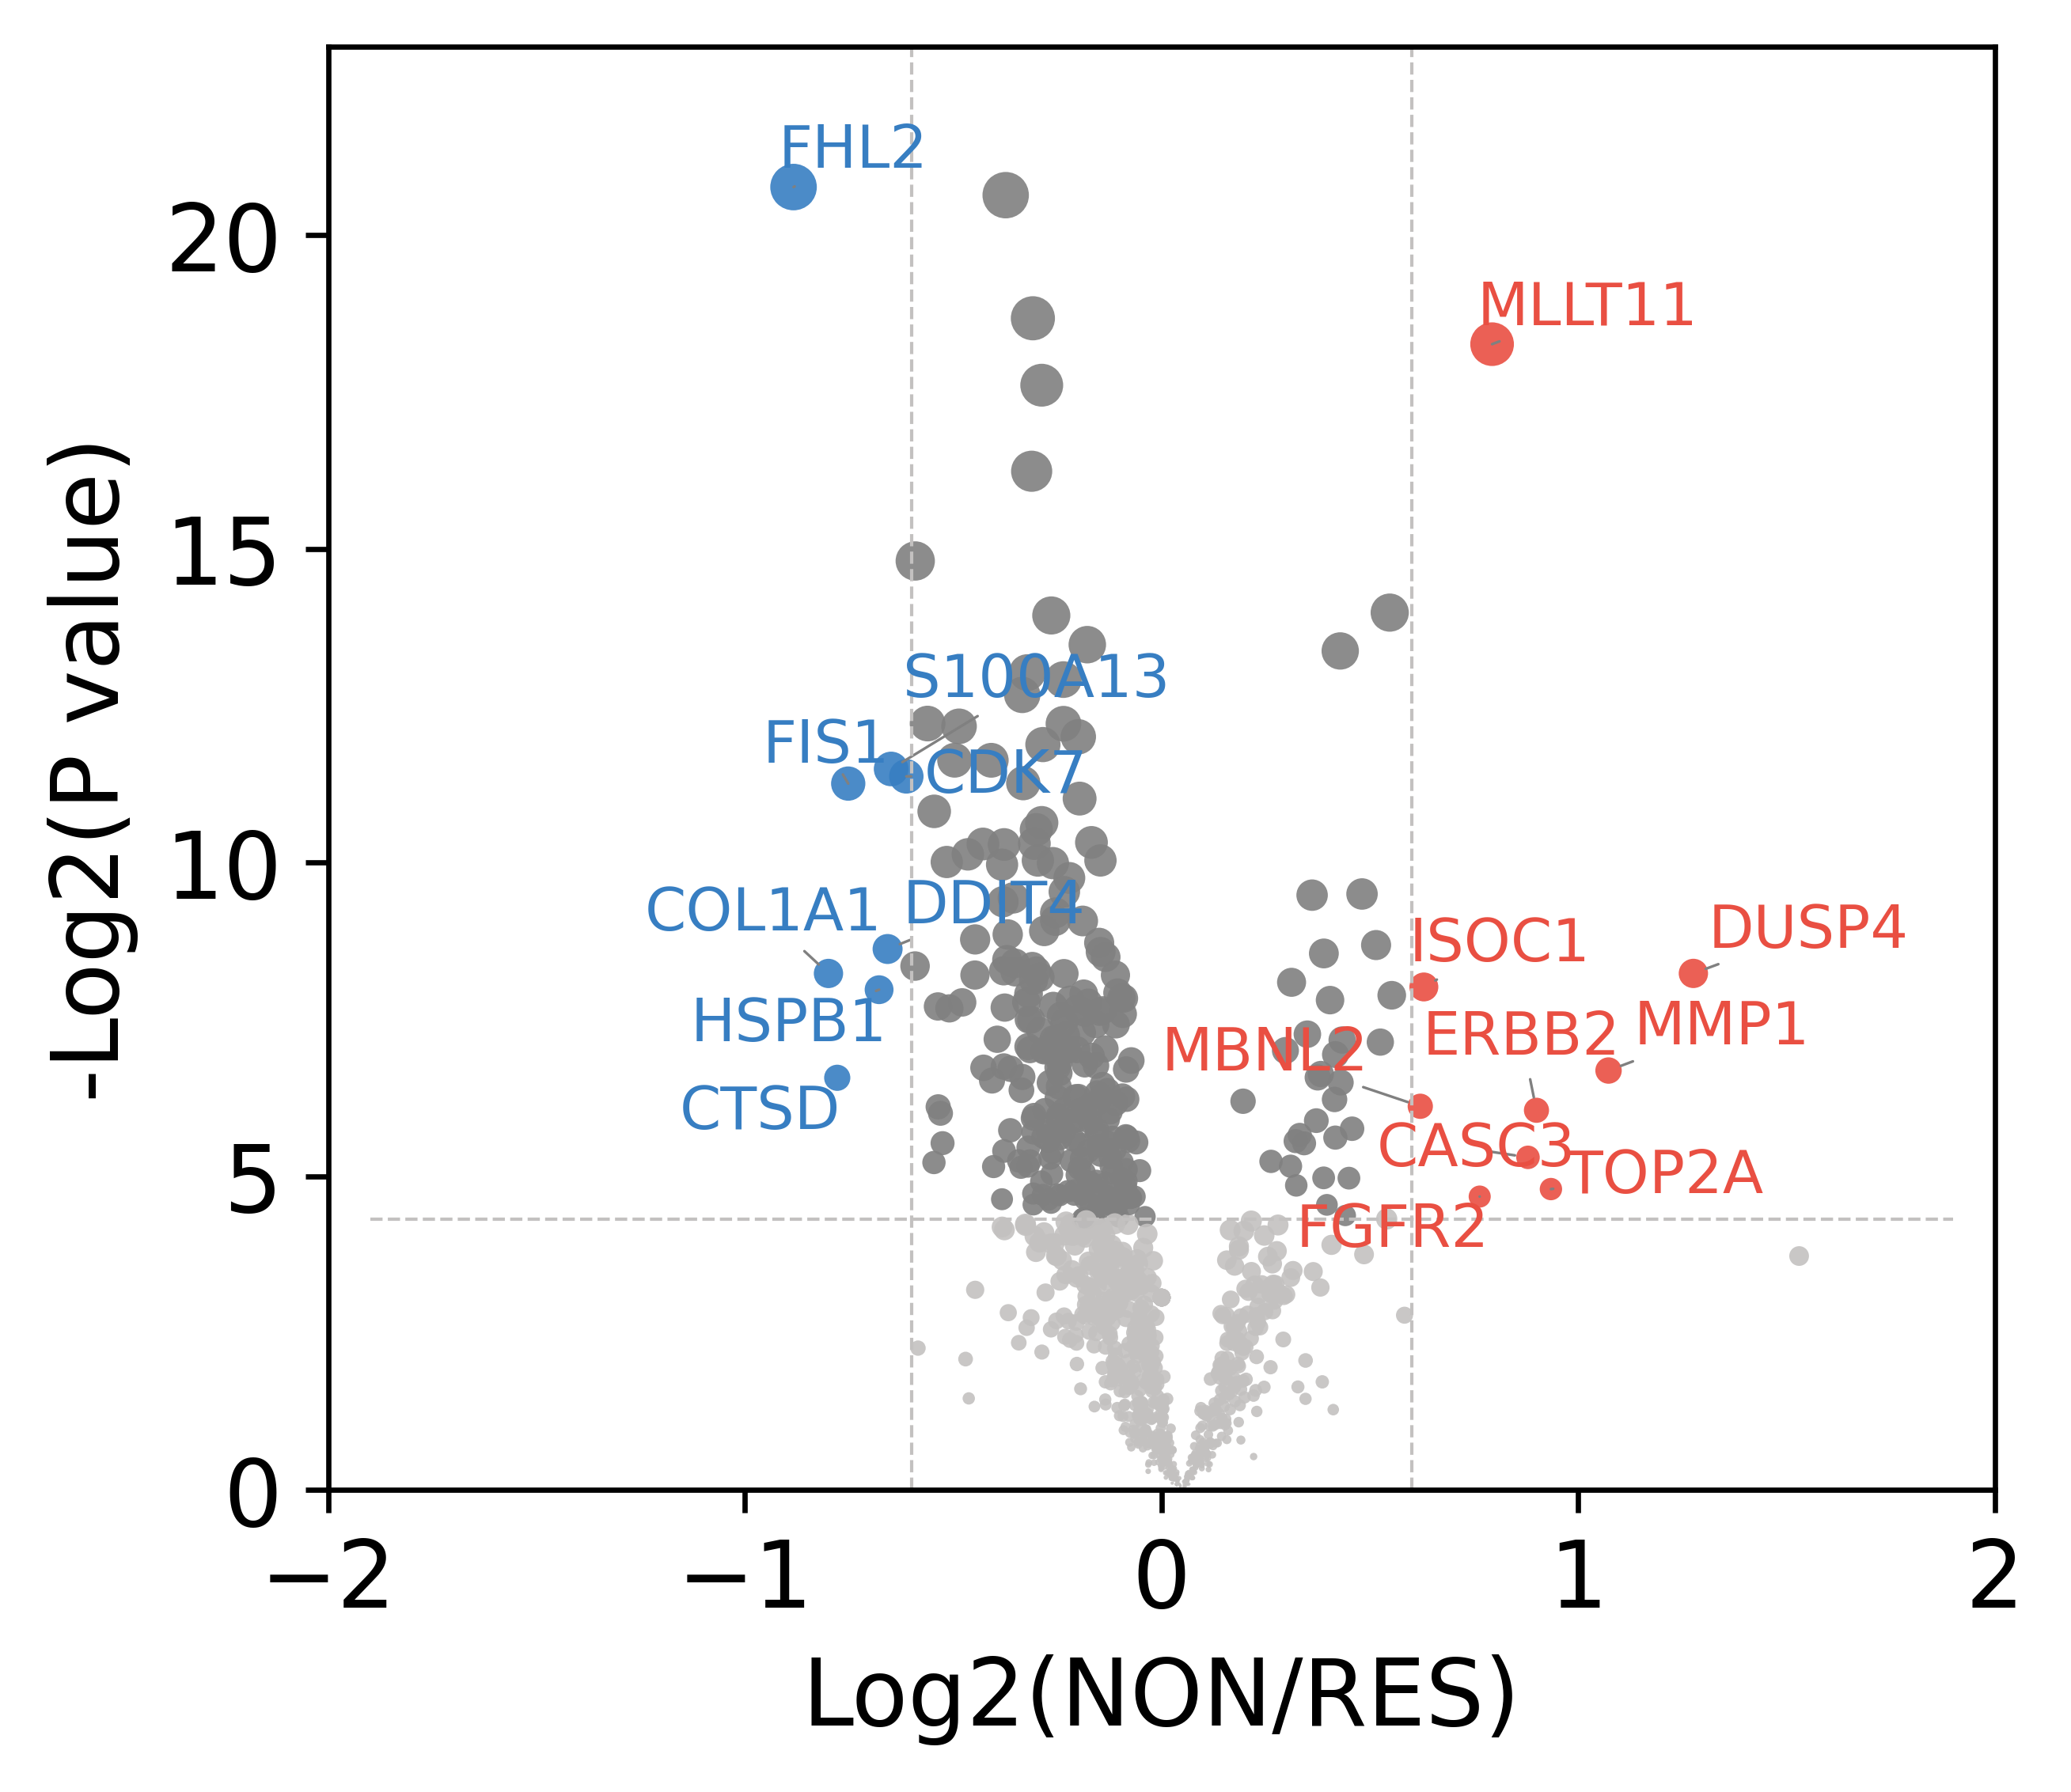

In [9]:
result = pd.DataFrame()
result['x'] = np.log2(pd_df['NON/RES'])
result['y'] = -np.log2(pd_df['P-value'])

x_threshold= 0.6
y_threshold= -np.log2(0.05)

result['group'] = 'grey'
result.loc[(result.x > x_threshold)&(result.y > y_threshold),'group'] = '#E94F42'
result.loc[(result.x < -x_threshold)&(result.y > y_threshold),'group'] = '#377EC2'
result.loc[result.y < y_threshold,'group'] = '#C3C1C0'
print(result.head())

xmin=-2
xmax=2
ymin=0
ymax=23

fig = plt.figure(dpi=300,figsize=(4.5, 4))
ax = fig.add_subplot()
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
ax.scatter(result['x'], result['y'], s=result['y']*2.4, c=result['group'], alpha=0.9, linewidths=0)
ax.set_ylabel('-Log2(P value)')
ax.set_xlabel('Log2(NON/RES)')

ax.vlines(-x_threshold, ymin, ymax, color='#C3C1C0',linestyle='dashed', linewidth=0.5)
ax.vlines(x_threshold, ymin, ymax, color='#C3C1C0',linestyle='dashed', linewidth=0.5)
ax.hlines(y_threshold, xmin+0.1, xmax-0.1, color='#C3C1C0',linestyle='dashed', linewidth=0.5)

texts = []
for i, row in result.iterrows():
    if row['group'] != 'grey' and row['group'] != '#C3C1C0':
        text = ax.text(row['x'], row['y'], str(i), fontsize=9, ha='right', va='bottom', color=row['group'])
        texts.append(text)

adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.4))

plt.grid(False)

plt.show()

# fig.savefig('figs/volcano_expression_ctl_non&res.svg',dpi=600,format='svg', bbox_inches='tight')

# response：trt v.s. ctl

In [19]:
def generate_df_trt_ctl(adata, group="Response"):
    
    adata = adata[adata.obs["Response group"]== group]
    
    response_num = adata.n_obs
    
    ls = (["ctl"]*response_num)
    ls.extend(["trt"]*response_num)
    
    df = pd.DataFrame(np.concatenate((adata.obsm["X_ctl"].T, adata.X.T), axis=1) , index=adata.var_names, columns=ls)
    df = np.power(2, df)
    
    df['TRT/CTL'] = np.mean(df.values[:,response_num:],1)/np.mean(df.values[:,:response_num],1)
    df['P-value'] = [stats.ttest_ind(a,b)[1] for a,b in zip(df.values[:,response_num:], df.values[:,:response_num])]


    return df

In [20]:
pd_df = generate_df_trt_ctl(adata2_breast, group="Response")
pd_df.head()

/root/data1/GY/Mambaforge/envs/openbiomed/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,ctl,ctl,ctl,ctl,ctl,ctl,ctl,ctl,ctl,ctl,...,trt,trt,trt,trt,trt,trt,trt,trt,TRT/CTL,P-value
gene_symbol,,,,,,,,,,,,,,,,,,,,,
DDR1,3122.583412,1705.110141,2184.969316,1815.108710,1212.357528,2199.548708,2300.487313,1940.683391,2824.042975,1719.777580,...,1472.084234,1911.030232,1473.194075,2373.395576,2300.349890,1198.883632,1447.470010,1288.362785,0.886248,0.003890
PAX8,964.051531,1064.119300,832.531688,900.748877,734.942845,840.785473,1443.340529,915.949452,704.658586,913.046206,...,1052.723380,1244.941075,779.160574,919.464954,1134.070327,1070.100499,882.971571,919.183710,1.010457,0.924792
RPS5,4050.742110,6749.180231,4069.354390,5388.910133,3509.495760,4129.774849,1609.419570,3911.392252,4924.934631,7133.054033,...,8419.976664,2937.373739,2733.792617,4886.385364,3568.646766,4222.368515,4743.156419,2570.521250,0.901746,0.055585
ABCF1,686.371087,542.834243,504.812387,552.677408,481.403018,818.685793,603.559750,603.581193,629.204801,592.567333,...,453.644687,517.009463,591.511424,781.735526,644.694486,414.197678,552.349887,671.377672,1.012690,0.980940
SPAG7,829.551192,1340.936039,795.405438,1221.728181,1049.028458,908.434756,830.041927,752.686252,1023.839404,876.243652,...,782.841681,716.716217,930.899511,921.265373,620.350175,918.116184,823.815735,682.404714,0.989109,0.537795


                    x         y    group
gene_symbol                             
DDR1        -0.174218  8.005858     grey
PAX8         0.015008  0.112799  #C3C1C0
RPS5        -0.149207  4.169172  #C3C1C0
ABCF1        0.018192  0.027763  #C3C1C0
SPAG7       -0.015799  0.894871  #C3C1C0


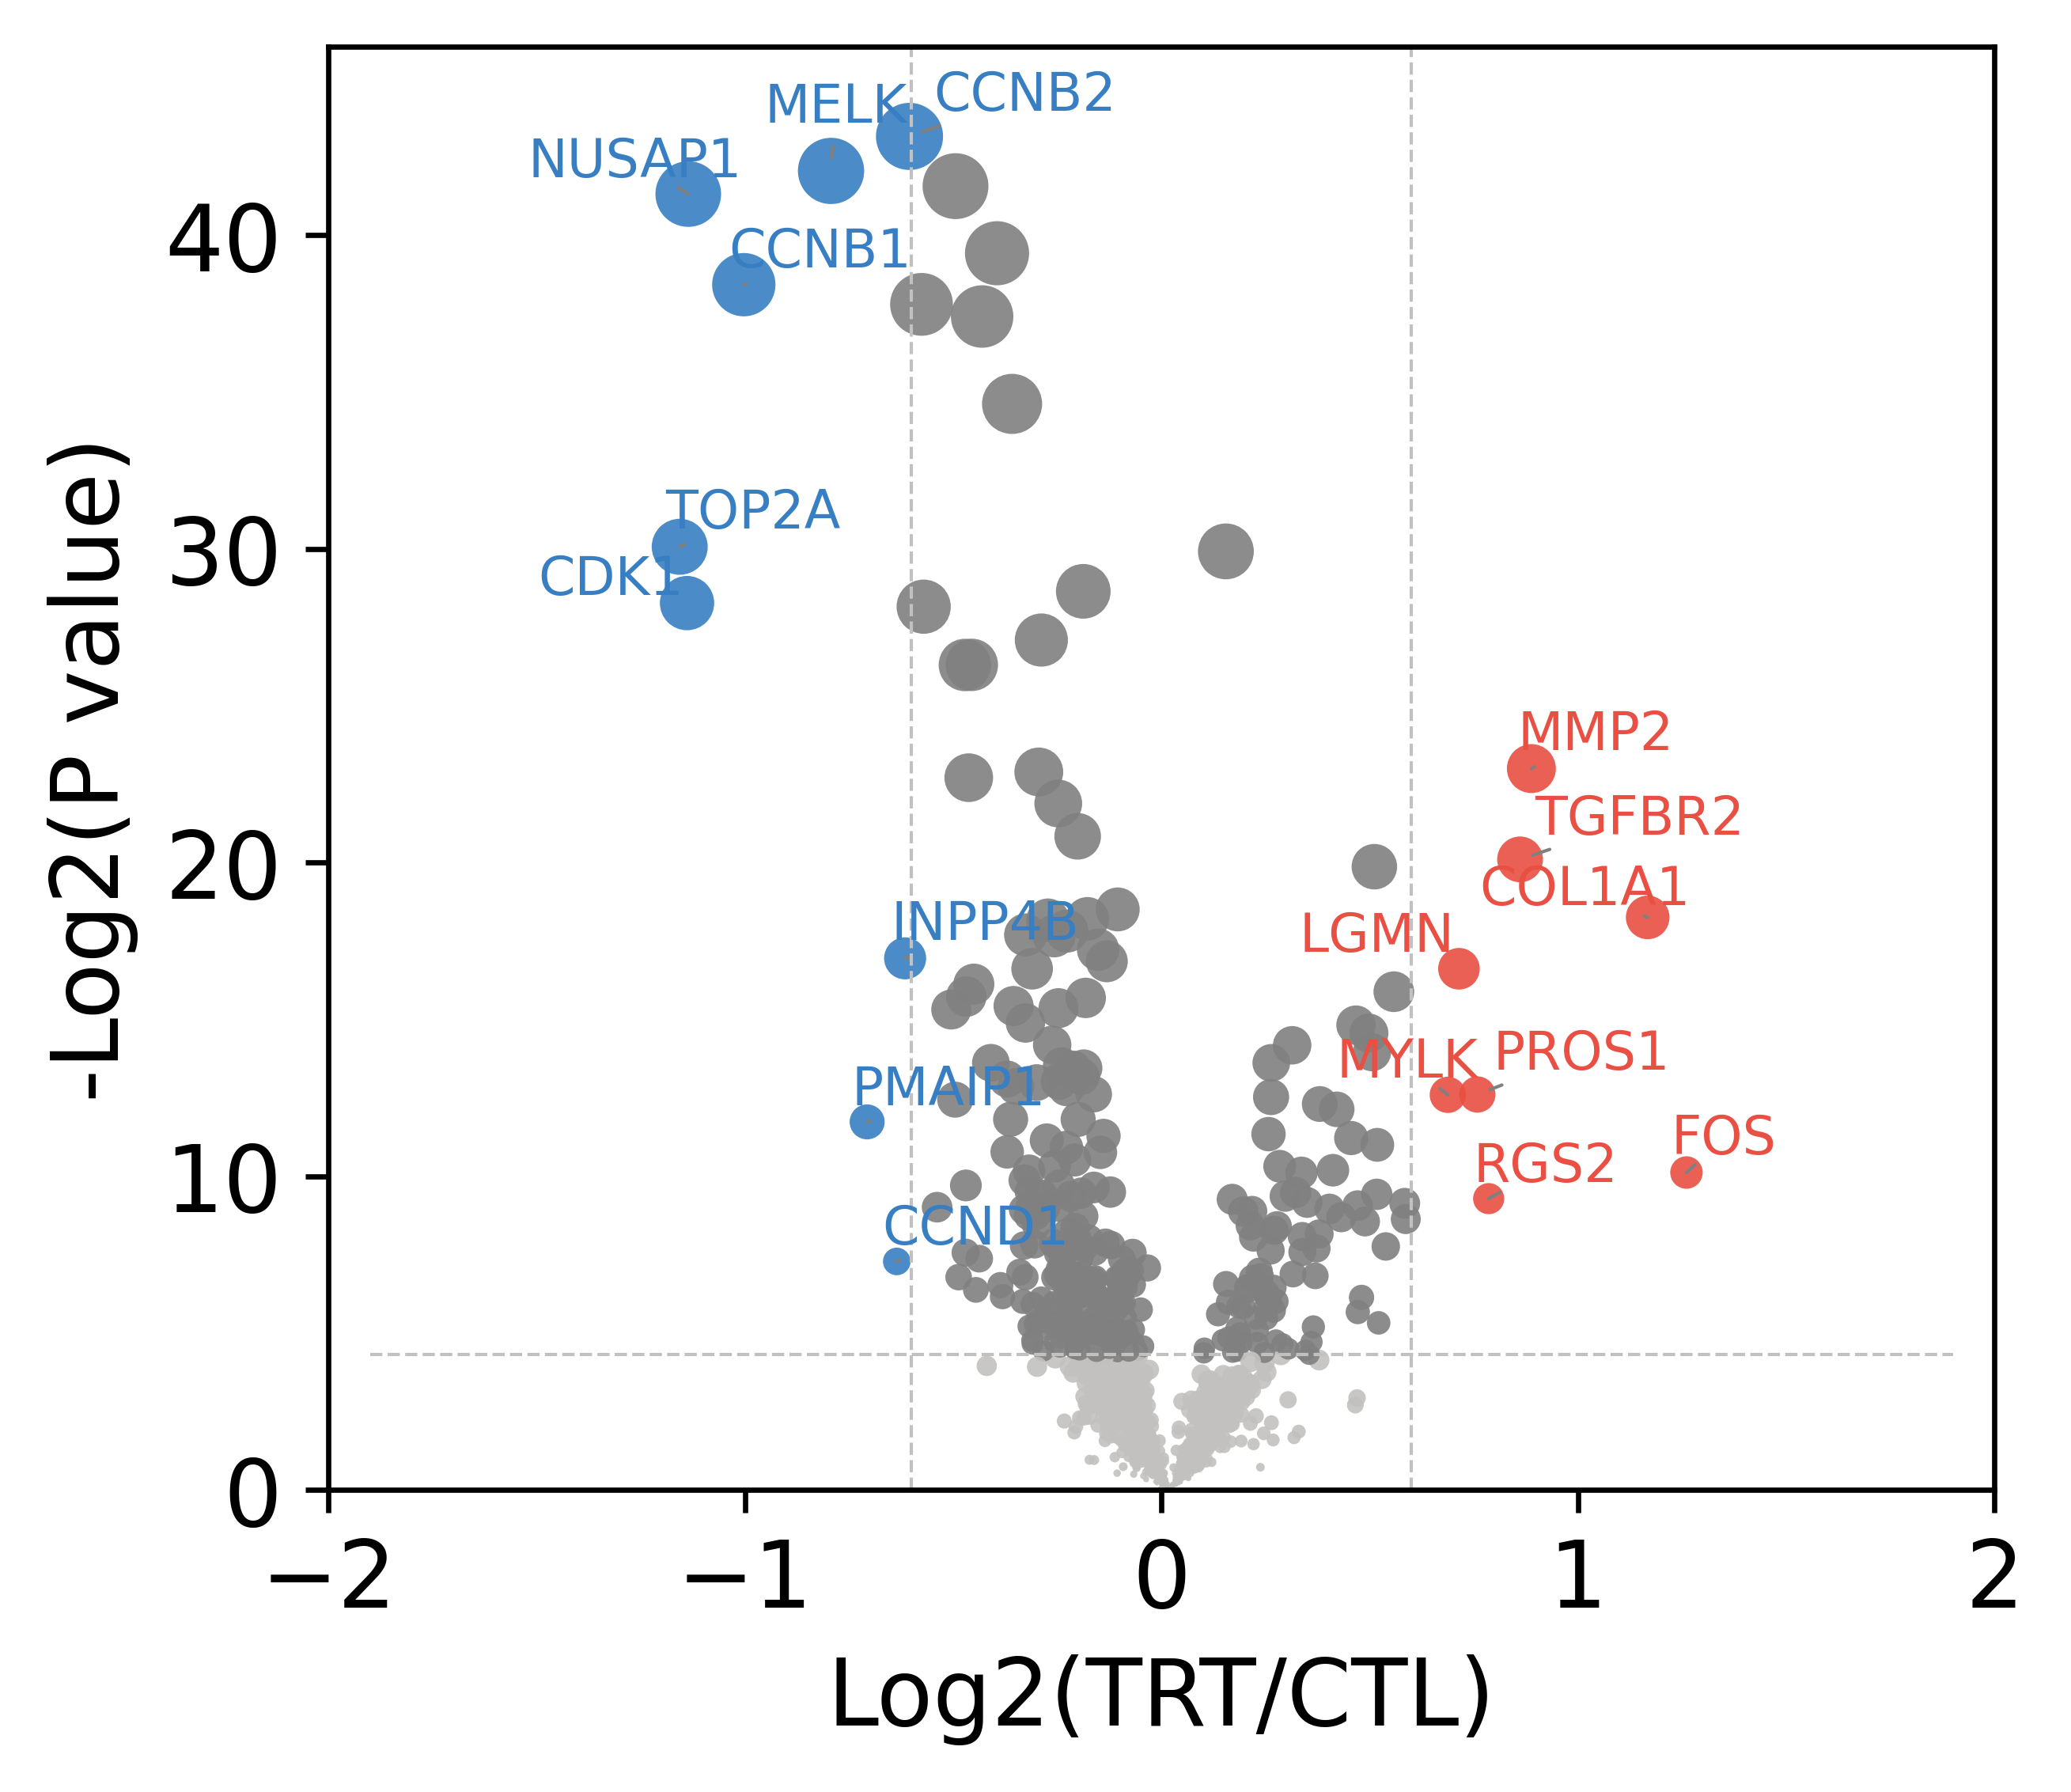

In [21]:
result = pd.DataFrame()
result['x'] = np.log2(pd_df['TRT/CTL'])
result['y'] = -np.log2(pd_df['P-value'])

x_threshold= 0.6
y_threshold= -np.log2(0.05)

result['group'] = 'grey'
result.loc[(result.x > x_threshold)&(result.y > y_threshold),'group'] = '#E94F42'
result.loc[(result.x < -x_threshold)&(result.y > y_threshold),'group'] = '#377EC2'
result.loc[result.y < y_threshold,'group'] = '#C3C1C0'
print(result.head())

xmin=-2
xmax=2
ymin=0
ymax=46


fig = plt.figure(dpi=300,figsize=(4.5,4))
ax = fig.add_subplot()
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
ax.scatter(result['x'], result['y'], s=result['y']*2.4, c=result['group'], alpha=0.9, linewidths=0)
ax.set_ylabel('-Log2(P value)')
ax.set_xlabel('Log2(TRT/CTL)')

ax.vlines(-x_threshold, ymin, ymax, color='#C3C1C0',linestyle='dashed', linewidth=0.5)
ax.vlines(x_threshold, ymin, ymax, color='#C3C1C0',linestyle='dashed', linewidth=0.5)
ax.hlines(y_threshold, xmin+0.1, xmax-0.1, color='#C3C1C0',linestyle='dashed', linewidth=0.5)

texts = []
for i, row in result.iterrows():
    if row['group'] != 'grey' and row['group'] != '#C3C1C0':
        text = ax.text(row['x'], row['y'], str(i), fontsize=8, ha='right', va='bottom', color=row['group'])
        texts.append(text)

adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.grid(False)

plt.show()

# fig.savefig('figs/volcano_response_group_trt_vs_ctl.svg',dpi=600, format='svg', bbox_inches="tight")

# Non-response：trt v.s. ctl

In [ ]:
pd_df = generate_df_trt_ctl(adata2_breast, group="Non-response")
pd_df.head()

/root/data1/GY/Mambaforge/envs/openbiomed/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,ctl,ctl,ctl,ctl,ctl,ctl,ctl,ctl,ctl,ctl,...,trt,trt,trt,trt,trt,trt,trt,trt,TRT/CTL,P-value
gene_symbol,,,,,,,,,,,,,,,,,,,,,
DDR1,1804.594851,1829.490290,1330.541187,1557.484872,2415.782473,2305.241748,1856.327468,2641.461478,2409.549828,2641.461478,...,1612.771882,2255.826413,1198.037748,2637.308322,2389.578189,2038.387088,1739.729120,1760.156520,0.959959,0.294800
PAX8,816.121598,613.432996,852.389696,607.738856,950.343422,987.034052,954.276776,930.301075,855.654002,930.301075,...,678.812005,1364.407201,794.819561,1012.905965,1119.367747,839.588682,958.403396,822.370271,1.035129,0.991244
RPS5,1312.828830,3164.760741,5724.081466,2841.807335,1415.402969,4350.333915,4014.419772,2472.038737,2296.243593,2472.038737,...,2053.408794,4126.438579,6576.279873,3020.591362,2444.943789,2608.102488,4061.421448,5706.812463,1.092733,0.674895
ABCF1,408.405254,717.986556,592.526765,487.131255,671.381175,1070.670065,670.553052,505.331363,733.569204,505.331363,...,409.573233,543.284894,621.824200,640.165406,1146.843861,570.120757,564.393724,474.114639,0.976975,0.492517
SPAG7,630.384654,609.487442,646.923136,699.326500,777.405888,634.798144,706.891427,806.113275,741.685389,806.113275,...,576.952018,796.194019,695.981158,655.036655,602.588129,614.949160,606.155863,465.947097,1.027513,0.899835


                    x         y    group
gene_symbol                             
DDR1        -0.058955  1.762194  #C3C1C0
PAX8         0.049811  0.012688  #C3C1C0
RPS5         0.127942  0.567265  #C3C1C0
ABCF1       -0.033606  1.021756  #C3C1C0
SPAG7        0.039157  0.152267  #C3C1C0


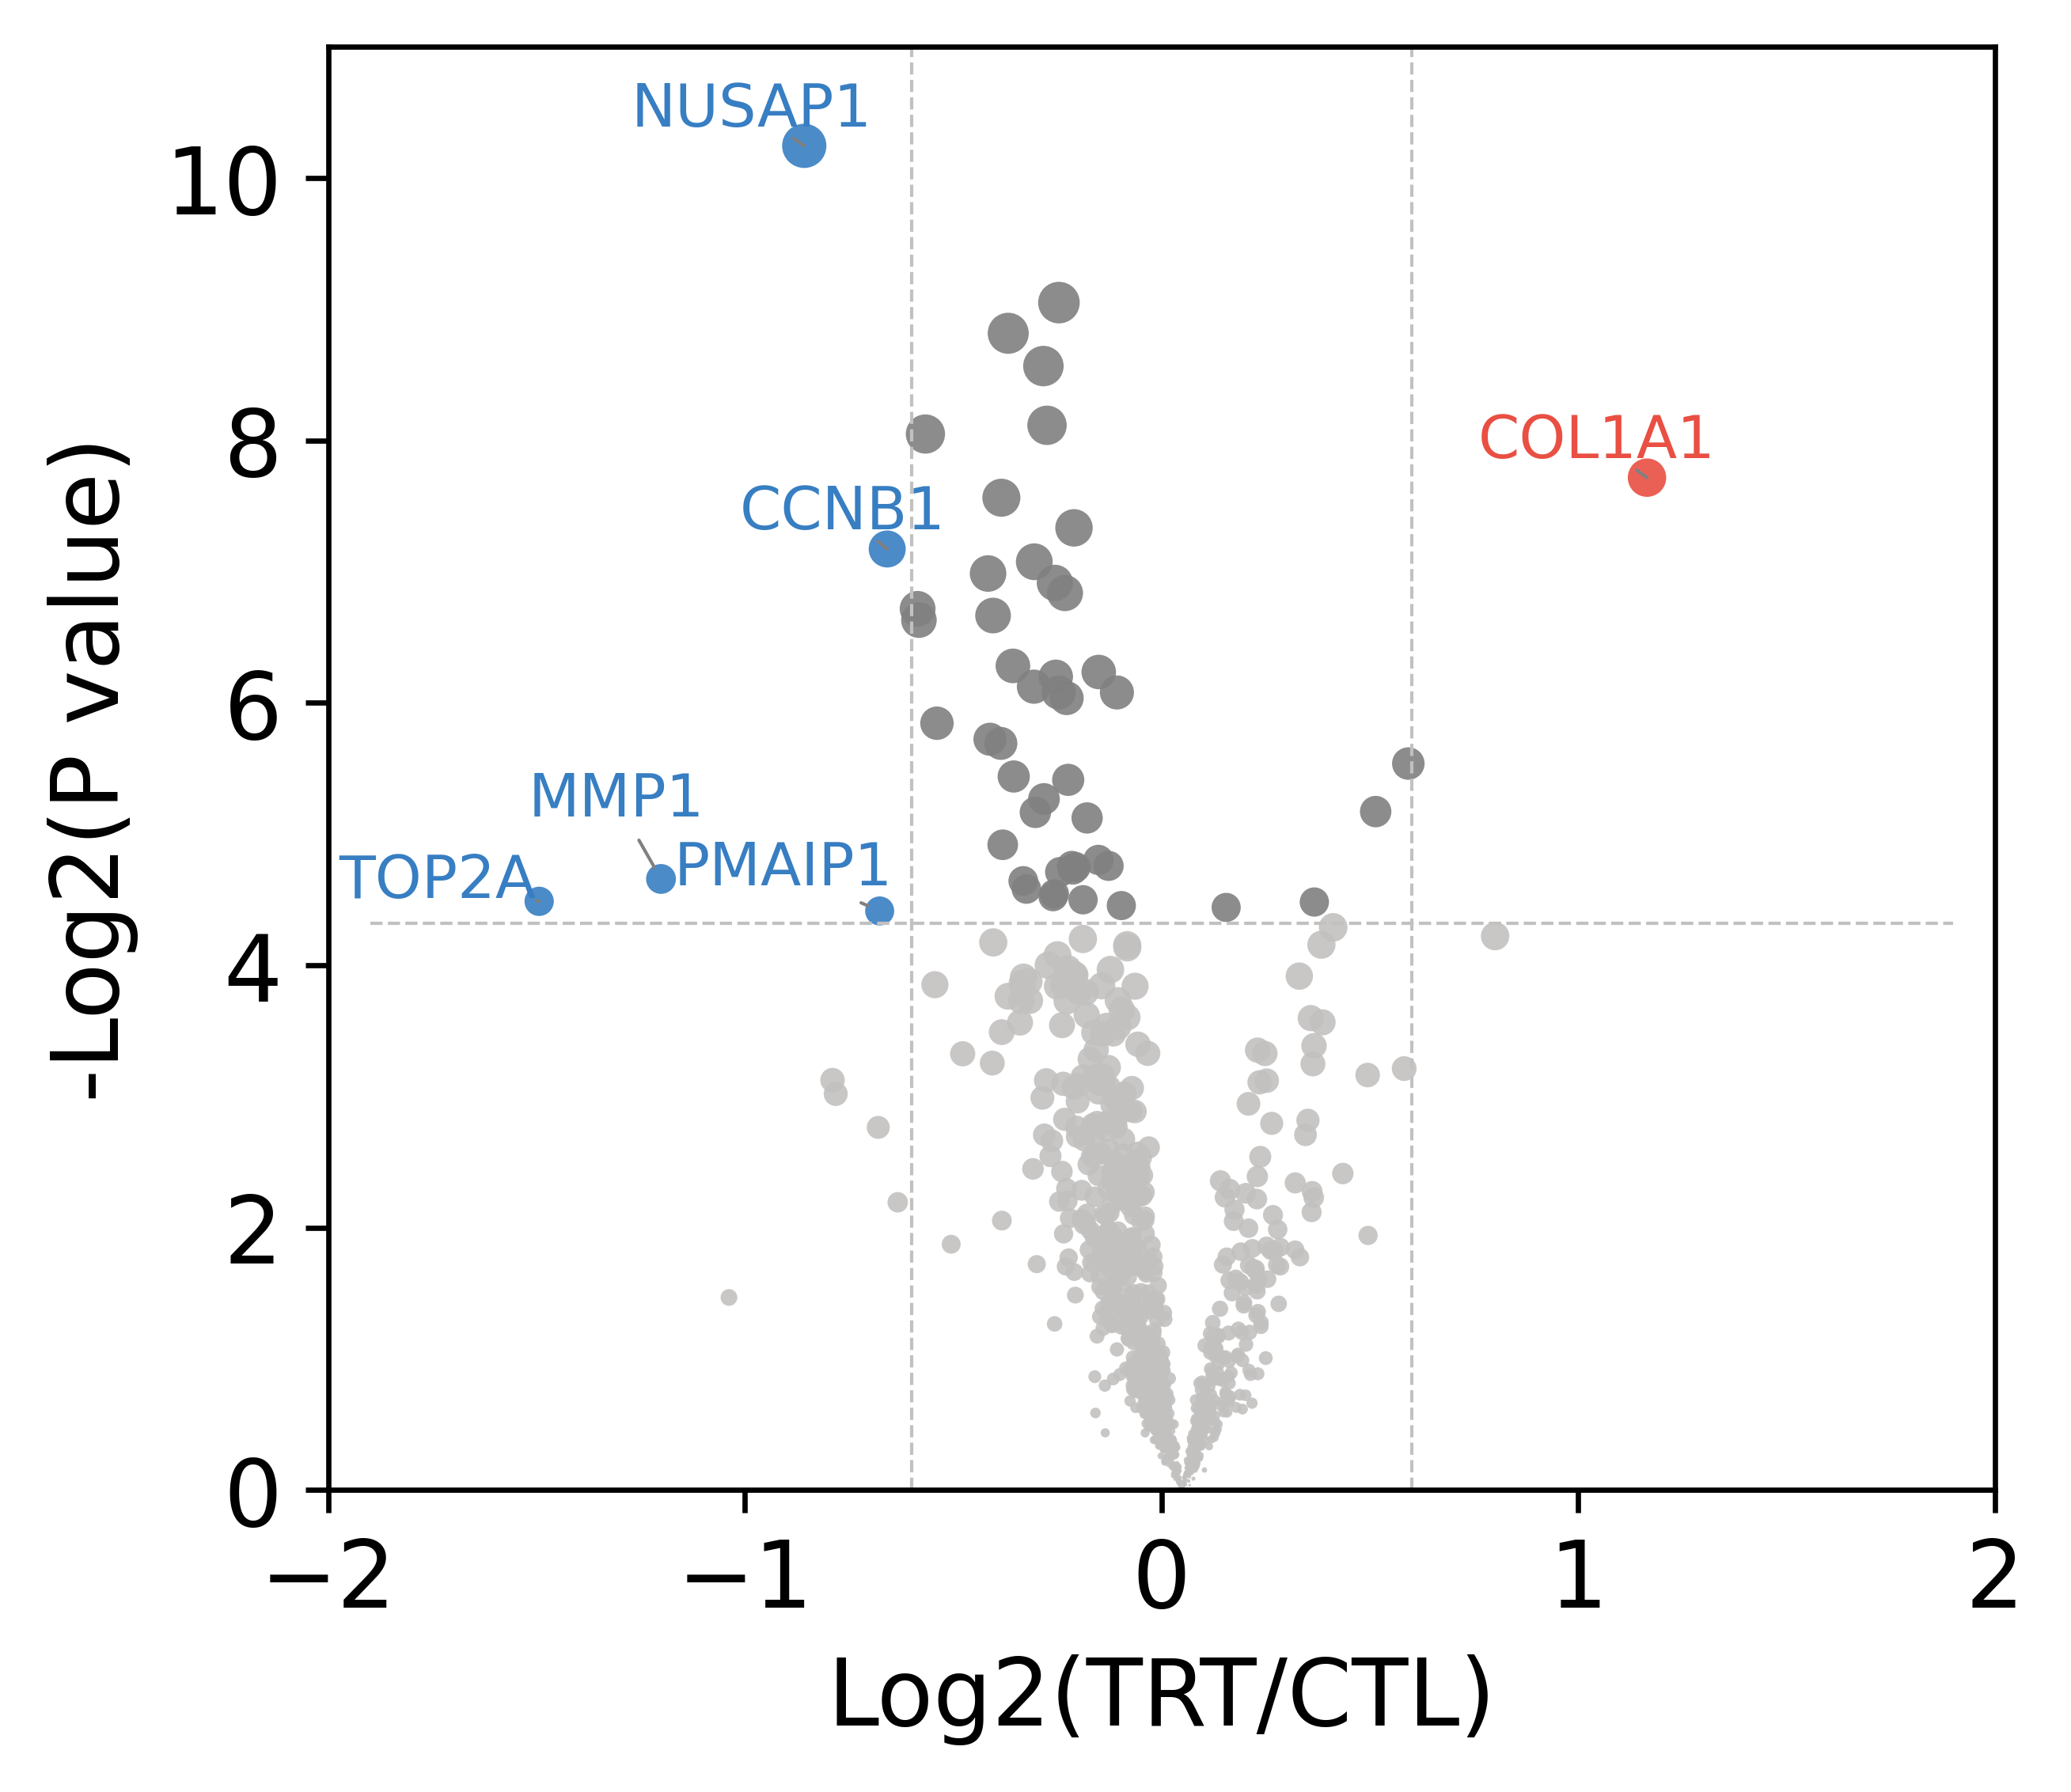

In [25]:
result = pd.DataFrame()
result['x'] = np.log2(pd_df['TRT/CTL'])
result['y'] = -np.log2(pd_df['P-value'])

x_threshold= 0.6
y_threshold= -np.log2(0.05)

result['group'] = 'grey'
result.loc[(result.x > x_threshold)&(result.y > y_threshold),'group'] = '#E94F42'
result.loc[(result.x < -x_threshold)&(result.y > y_threshold),'group'] = '#377EC2'
result.loc[result.y < y_threshold,'group'] = '#C3C1C0'
print(result.head())

xmin=-2
xmax=2
ymin=0
ymax=11

fig = plt.figure(dpi=300,figsize=(4.5,4))
ax = fig.add_subplot()
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
ax.scatter(result['x'], result['y'], s=result['y']*4.4, c=result['group'], alpha=0.9, linewidths=0)
ax.set_ylabel('-Log2(P value)')
ax.set_xlabel('Log2(TRT/CTL)')


ax.vlines(-x_threshold, ymin, ymax, color='#C3C1C0',linestyle='dashed', linewidth=0.5)
ax.vlines(x_threshold, ymin, ymax, color='#C3C1C0',linestyle='dashed', linewidth=0.5)
ax.hlines(y_threshold, xmin+0.1, xmax-0.1, color='#C3C1C0',linestyle='dashed', linewidth=0.5)

texts = []
for i, row in result.iterrows():
    if row['group'] != 'grey' and row['group'] != '#C3C1C0':
        text = ax.text(row['x'], row['y'], str(i), fontsize=9, ha='right', va='bottom', color=row['group'])
        texts.append(text)

adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.grid(False)

plt.show()

# fig.savefig('figs/volcano_non-response_group_trt_vs_ctl.svg',dpi=600, format='svg', bbox_inches="tight")